In [217]:
import numpy as np
import pandas as pd
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error #不太靠谱 太劲大求了。差的平方的均值
from sklearn.metrics import explained_variance_score #越小代表结果越差
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score #交叉验证
import matplotlib.pyplot as plt
import matplotlib
from sklearn.tree import DecisionTreeRegressor
import matplotlib.dates as mdate
from sklearn.grid_search import GridSearchCV
import xgboost as xgb
from sklearn.ensemble import BaggingRegressor
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
%matplotlib inline
X = pd.read_excel('./input5.xlsx')
#X['dayofyear'] = X['日期'].apply(lambda x : x.dayofyear)
X['year'] = X['日期'].apply(lambda x : x.year)
X['dayofweek'] =  X['日期'].apply(lambda x: x.dayofweek)
X['dayofmonth'] = X['日期'].apply(lambda x: x.day)
X['前一天供水量'] = X['总供水量'].shift(1)
X['再往前一天供水量'] = X['总供水量'].shift(2)
X['与前一天空气质量差'] = X['空气质量指数'] - X['空气质量指数'].shift(1)
X['与前一天湿度差值'] = X['平均相对湿度'] - X['平均相对湿度'].shift(1)
X['与前一天最低气温差'] = X['最低气温'] - X['最低气温'].shift(1)
X['与前一天最高气温差'] = X['最高气温'] - X['最高气温'].shift(1)
X['与前一天平均温度差'] = X['平均气温'] - X['平均气温'].shift(1)
X = X[~pd.isnull(X['再往前一天供水量'])]
y = X.pop('总供水量')
date = X['日期']
drop = ['日期','星期','24节气','PM2.5','PM10','SO2','CO','NO2','O3_8h']
X.drop(drop,axis = 1,inplace = True)
X_reset = X.reset_index(drop = True)

In [218]:
sunday_index = X_reset.loc[X_reset['节假日'] == '周末'].index
for i in sunday_index:
    if X_reset.loc[i,'dayofweek'] == 6:
         X_reset.loc[i,'节假日'] = '周日'
    if X_reset.loc[i,'dayofweek'] == 5:
         X_reset.loc[i,'节假日'] = '周六'

In [219]:
X_input = pd.get_dummies(X_reset)

## 随机森林

Text(0.5,1,'随机森林平均偏差')

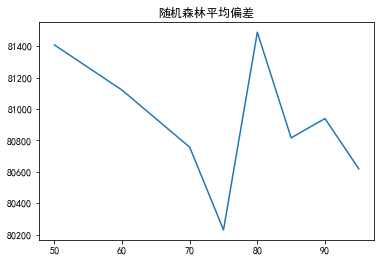

In [4]:
from sklearn.ensemble import RandomForestRegressor#随机森林回归
random_params = [50,60,70,75,80,85,90,95]
random_test_scores = []
for param in random_params:
    clf = RandomForestRegressor(n_estimators=param)
    test_score = -cross_val_score(clf, X_input, y, cv=10, scoring='neg_mean_absolute_error')
    random_test_scores.append(np.mean(test_score))
plt.plot(random_params, random_test_scores)
plt.title("随机森林平均偏差")

69350.72761904767
0.016282733501504373


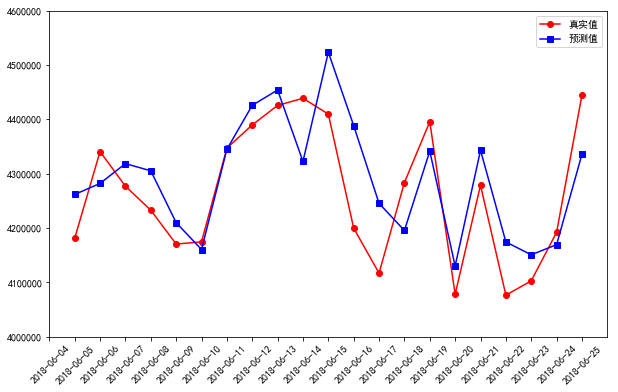

In [150]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.dates as mdate
clf = RandomForestRegressor(n_estimators=75)
day = 21
Predict(clf,X_input[:-day],y[:-day],X_input[-day:],y[-day:],day,date[-day:])

In [9]:
clf_fr = RandomForestRegressor(n_estimators=75)
test_score = -cross_val_score(clf_fr, X_input, y, cv=10, scoring='neg_mean_absolute_error')
print(np.mean(test_score))

80348.42445151175


In [18]:
80648 / np.mean(y)

0.018684467001106483

In [8]:
X_train,X_test,y_train,y_test = train_test_split(X_input,y,test_size = 0.2)
#将整个数据集分成训练集和测试集，X_train和Y_train是训练集，其他两个是测试集
clf_fr = RandomForestRegressor(n_estimators=75)
#根据以上图 选择 最适合的参数
clf_fr.fit(X_train,y_train)
#这一步是在训练模型
pre = clf_fr.predict(X_test)
#这一步是对测试集做预测，输出pre就是预测值。
np.mean(abs(pre - y_test)/y_test)

0.017641542821687742

## Xgboost


In [5]:
X_train,X_test,y_train,y_test = train_test_split(X_input,y,test_size = 0.2)

In [33]:
from sklearn.grid_search import GridSearchCV
import xgboost as xgb

c:\python3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## 1. 首先挑选最优的 n_estimators

In [21]:
if __name__ == '__main__':
    cv_params = {'n_estimators': [90,100,110]}
    other_params = {'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
                    'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}
    model = xgb.XGBRegressor(**other_params)
    optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='mean_absolute_error', cv=10, verbose=1, n_jobs=4)
    optimized_GBM.fit(X_input, y)
    evalute_result = optimized_GBM.grid_scores_
    print('每轮迭代运行结果:{0}'.format(evalute_result))
    print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
    print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    3.5s finished


每轮迭代运行结果:[mean: -74314.63057, std: 25380.16795, params: {'n_estimators': 90}, mean: -74172.40791, std: 25262.61873, params: {'n_estimators': 100}, mean: -74265.14013, std: 25439.37083, params: {'n_estimators': 110}]
参数的最佳取值：{'n_estimators': 100}
最佳模型得分:-74172.40790870489


## 2. 选取n_estimators = 100  第二步确定最好的max_depth和 min_child_weight

In [22]:
if __name__ == '__main__':
    cv_params = {'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 'min_child_weight': [2, 3, 4, 5, 6,7]}
    other_params = {'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
                    'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}
    model = xgb.XGBRegressor(**other_params)
    optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='mean_absolute_error', cv=10, verbose=1, n_jobs=4)
    optimized_GBM.fit(X_input, y)
    evalute_result = optimized_GBM.grid_scores_
    print('每轮迭代运行结果:{0}'.format(evalute_result))
    print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
    print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   10.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   28.6s
[Parallel(n_jobs=4)]: Done 480 out of 480 | elapsed:   32.0s finished


每轮迭代运行结果:[mean: -74915.48912, std: 24417.63750, params: {'max_depth': 3, 'min_child_weight': 2}, mean: -75129.69984, std: 24627.03200, params: {'max_depth': 3, 'min_child_weight': 3}, mean: -74607.04724, std: 24349.75809, params: {'max_depth': 3, 'min_child_weight': 4}, mean: -75307.55414, std: 25028.83244, params: {'max_depth': 3, 'min_child_weight': 5}, mean: -74627.14862, std: 24709.02951, params: {'max_depth': 3, 'min_child_weight': 6}, mean: -75475.75504, std: 24561.98162, params: {'max_depth': 3, 'min_child_weight': 7}, mean: -75624.09076, std: 24816.61607, params: {'max_depth': 4, 'min_child_weight': 2}, mean: -74975.37818, std: 25514.75364, params: {'max_depth': 4, 'min_child_weight': 3}, mean: -75001.19241, std: 24988.40387, params: {'max_depth': 4, 'min_child_weight': 4}, mean: -74462.24018, std: 24284.73215, params: {'max_depth': 4, 'min_child_weight': 5}, mean: -74858.03424, std: 25354.63248, params: {'max_depth': 4, 'min_child_weight': 6}, mean: -74116.37792, std: 24328.62

## 3. max_depth = 7 min_child_weight = 3 结果最好
## 接下来我们调参数Gamma    
####  注：在节点分裂时，只有分裂后损失函数的值下降了，才会分裂这个节点。Gamma指定了节点分裂所需的最小损失函数下降值。 这个参数的值越大，算法越保守。这个参数的值和损失函数息息相关，所以是需要调整的。 

In [23]:
if __name__ == '__main__':
    cv_params = {'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]}
    other_params = {'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 7, 'min_child_weight': 3, 'seed': 0,
                    'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}
    model = xgb.XGBRegressor(**other_params)
    optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='mean_absolute_error', cv=10, verbose=1, n_jobs=4)
    optimized_GBM.fit(X_input, y)
    evalute_result = optimized_GBM.grid_scores_
    print('每轮迭代运行结果:{0}'.format(evalute_result))
    print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
    print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.8s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:    9.1s finished


每轮迭代运行结果:[mean: -73201.39968, std: 24938.85274, params: {'gamma': 0.1}, mean: -73201.39968, std: 24938.85274, params: {'gamma': 0.2}, mean: -73201.39968, std: 24938.85274, params: {'gamma': 0.3}, mean: -73201.39968, std: 24938.85274, params: {'gamma': 0.4}, mean: -73201.39968, std: 24938.85274, params: {'gamma': 0.5}, mean: -73201.39968, std: 24938.85274, params: {'gamma': 0.6}]
参数的最佳取值：{'gamma': 0.1}
最佳模型得分:-73201.39968152867


### 4. 接着是subsample以及 colsample_bytree
   subsample [缺省值=1]
   这个参数控制对于每棵树，随机采样的比例。 减小这个参数的值，算法会更加保守，避免过拟合。但是，如果这个值设置得过小，它可能会导致欠拟合。 
   典型值：0.5-1，0.5代表平均采样，防止过拟合.
   范围: (0,1]
   colsample_bytree [缺省值=1]
   用来控制每棵随机采样的列数的占比(每一列是一个特征)。 典型值：0.5-1
   范围: (0,1]

In [24]:
if __name__ == '__main__':
    cv_params = {'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]}
    other_params = {'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 7, 'min_child_weight': 3, 'seed': 0,
                    'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.1, 'reg_alpha': 0, 'reg_lambda': 1}
    model = xgb.XGBRegressor(**other_params)
    optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='mean_absolute_error', cv=10, verbose=1, n_jobs=4)
    optimized_GBM.fit(X_input, y)
    evalute_result = optimized_GBM.grid_scores_
    print('每轮迭代运行结果:{0}'.format(evalute_result))
    print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
    print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.1s
[Parallel(n_jobs=4)]: Done 160 out of 160 | elapsed:   14.7s finished


每轮迭代运行结果:[mean: -75172.79114, std: 25764.27274, params: {'colsample_bytree': 0.6, 'subsample': 0.6}, mean: -74043.12872, std: 23402.53370, params: {'colsample_bytree': 0.6, 'subsample': 0.7}, mean: -73479.94108, std: 23332.06879, params: {'colsample_bytree': 0.6, 'subsample': 0.8}, mean: -74760.86385, std: 24444.52287, params: {'colsample_bytree': 0.6, 'subsample': 0.9}, mean: -74292.16932, std: 25332.58155, params: {'colsample_bytree': 0.7, 'subsample': 0.6}, mean: -73913.20594, std: 24920.86713, params: {'colsample_bytree': 0.7, 'subsample': 0.7}, mean: -73911.06051, std: 23945.05125, params: {'colsample_bytree': 0.7, 'subsample': 0.8}, mean: -74948.04432, std: 24362.05179, params: {'colsample_bytree': 0.7, 'subsample': 0.9}, mean: -74077.43604, std: 25087.58723, params: {'colsample_bytree': 0.8, 'subsample': 0.6}, mean: -75325.61040, std: 24030.82703, params: {'colsample_bytree': 0.8, 'subsample': 0.7}, mean: -73201.39968, std: 24938.85274, params: {'colsample_bytree': 0.8, 'subsamp

### 5.  紧接着就是：reg_alpha以及reg_lambda： 

#### lambda [缺省值=1，别名: reg_lambda]
权重的L2正则化项。(和Ridge regression类似)。 这个参数是用来控制XGBoost的正则化部分的。虽然大部分数据科学家很少用到这个参数，但是这个参数在
减少过拟合上还是可以挖掘出更多用处的

##### alpha [缺省值=0，别名: reg_alpha]
权重的L1正则化项。(和Lasso regression类似)。 可以应用在很高维度的情况下，使得算法的速度更快。

In [25]:
if __name__ == '__main__':
    cv_params = {'reg_alpha': [0.05, 0.1, 1, 2, 3], 'reg_lambda': [0.05, 0.1, 1, 2, 3]}
    other_params = {'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 7, 'min_child_weight': 3, 'seed': 0,
                    'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.1, 'reg_alpha': 0, 'reg_lambda': 1}
    model = xgb.XGBRegressor(**other_params)
    optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='mean_absolute_error', cv=10, verbose=1, n_jobs=4)
    optimized_GBM.fit(X_input, y)
    evalute_result = optimized_GBM.grid_scores_
    print('每轮迭代运行结果:{0}'.format(evalute_result))
    print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
    print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))

Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   15.5s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:   19.5s finished


每轮迭代运行结果:[mean: -75225.32882, std: 28108.44296, params: {'reg_alpha': 0.05, 'reg_lambda': 0.05}, mean: -74627.66322, std: 26256.49180, params: {'reg_alpha': 0.05, 'reg_lambda': 0.1}, mean: -73201.39597, std: 24938.85286, params: {'reg_alpha': 0.05, 'reg_lambda': 1}, mean: -75007.23859, std: 23715.31499, params: {'reg_alpha': 0.05, 'reg_lambda': 2}, mean: -74695.36996, std: 23053.01026, params: {'reg_alpha': 0.05, 'reg_lambda': 3}, mean: -75225.32670, std: 28108.41209, params: {'reg_alpha': 0.1, 'reg_lambda': 0.05}, mean: -74627.67012, std: 26256.49173, params: {'reg_alpha': 0.1, 'reg_lambda': 0.1}, mean: -73201.39358, std: 24938.85614, params: {'reg_alpha': 0.1, 'reg_lambda': 1}, mean: -75007.23912, std: 23715.31288, params: {'reg_alpha': 0.1, 'reg_lambda': 2}, mean: -74695.36306, std: 23053.01309, params: {'reg_alpha': 0.1, 'reg_lambda': 3}, mean: -75347.00212, std: 27999.51206, params: {'reg_alpha': 1, 'reg_lambda': 0.05}, mean: -74934.36943, std: 26190.68100, params: {'reg_alpha': 1

## 6. 最后就是learning_rate，一般这时候要调小学习率来测试：

In [26]:
if __name__ == '__main__':
    cv_params = {'learning_rate': [0.01, 0.05, 0.07, 0.1, 0.2]}
    other_params = {'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 7, 'min_child_weight': 3, 'seed': 0,
                    'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.1, 'reg_alpha': 1, 'reg_lambda': 1,
                    }
    model = xgb.XGBRegressor(**other_params)
    optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='mean_absolute_error', cv=10, verbose=1, n_jobs=4)
    optimized_GBM.fit(X_input, y)
    evalute_result = optimized_GBM.grid_scores_
    print('每轮迭代运行结果:{0}'.format(evalute_result))
    print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
    print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    4.7s finished


每轮迭代运行结果:[mean: -1589081.90897, std: 97867.65880, params: {'learning_rate': 0.01}, mean: -79055.73089, std: 24693.56792, params: {'learning_rate': 0.05}, mean: -73700.06237, std: 24380.34322, params: {'learning_rate': 0.07}, mean: -73201.36837, std: 24938.85875, params: {'learning_rate': 0.1}, mean: -78448.99469, std: 24824.09250, params: {'learning_rate': 0.2}]
参数的最佳取值：{'learning_rate': 0.1}
最佳模型得分:-73201.36836518046


In [35]:
if __name__ == '__main__':
    cv_params = {'learning_rate': [0.05, 0.07, 0.1, 0.2],'n_estimators': [90,100,110],'reg_alpha': [0.05, 0.1, 1], 
                 'reg_lambda': [0.1, 1, 2],'subsample': [ 0.7, 0.8, 0.9], 'colsample_bytree': [0.7, 0.8, 0.9],
                'max_depth': [ 5, 6, 7, 8, 9], 'min_child_weight': [2, 3, 4],'gamma': [0.1, 0.2]}
    other_params = {'seed': 0}
    model = xgb.XGBRegressor(**other_params)
    optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='mean_absolute_error', cv=10, verbose=1, n_jobs=4)
    optimized_GBM.fit(X_input, y)
    evalute_result = optimized_GBM.grid_scores_
    print('每轮迭代运行结果:{0}'.format(evalute_result))
    print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
    print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))

Fitting 10 folds for each of 29160 candidates, totalling 291600 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    9.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   20.3s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:   37.2s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:   56.3s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 4992 tasks      | elapsed:  4.0min
[Parallel(n_jobs=4)]: Done 6042 tasks      | elapsed:  5.0min
[Parallel(n_jobs=4)]: Done 7192 tasks      | elapsed:  6.1min
[Parallel(n_jobs=4)]: Done 8442 tasks      | elapsed:  7.4min
[Parallel(n_jobs=4)]: Done 9792 tasks      | elapsed:  8.9min
[Parallel(n_jobs=4)]: Done 11242 tasks      | elapsed: 10.7min
[Parallel(n_jobs=4)]: Done 12792 tasks      | elapsed: 12.2min
[Parallel(

In [37]:
print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))

参数的最佳取值：{'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.07, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 110, 'reg_alpha': 0.1, 'reg_lambda': 2, 'subsample': 0.7}
最佳模型得分:-71687.15684713375


### 以上即为调参的全部过程，模型的最佳参数为：
{'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.07, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 110, 
 'reg_alpha': 0.1, 'reg_lambda': 2, 'subsample': 0.7}

#### xgb.XGBRegressor(colsample_bytree = 0.9,gamma = 0.1,learining_rate = 0.07,max_depth = 6, min_child_weight= 4,n_estimators=110,reg_alpha = 0.1,reg_lambda = 2,subsample = 0.7)

In [146]:
X_train,X_test,y_train,y_test = train_test_split(X_input,y,test_size = 0.2)
#将整个数据集分成训练集和测试集，X_train和Y_train是训练集，其他两个是测试集
clf = xgb.XGBRegressor(colsample_bytree = 0.9,gamma = 0.1,learining_rate = 0.07,
                       max_depth = 6, min_child_weight= 4,n_estimators=110,reg_alpha = 0.1,reg_lambda = 2,subsample = 0.7)
#根据以上图 选择 最适合的参数
clf.fit(X_train,y_train)
#这一步是在训练模型
pre = clf.predict(X_test)
#这一步是对测试集做预测，输出pre就是预测值。
np.mean(abs(pre - y_test))

65963.18005181347

74375.27561310191
69960.08489641656


## Bagging

Text(0.5,1,'bagging平均偏差')

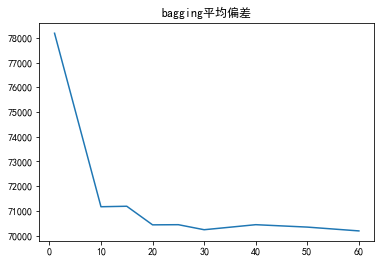

In [55]:
from sklearn.ensemble import BaggingRegressor
bag_params = [1,10,15,20,25,30,40,50,60]
bag_test_score = []
for par in bag_params:
    bag_reg = BaggingRegressor(n_estimators = par,base_estimator = xgb.XGBRegressor(colsample_bytree = 0.9,gamma = 0.1,learining_rate = 0.07,max_depth = 6, min_child_weight= 4,n_estimators=110,reg_alpha = 0.1,reg_lambda = 2,subsample = 0.7))
    bag_test_score.append(np.mean(-cross_val_score(bag_reg,X_input,y,cv = 10,scoring= 'neg_mean_absolute_error')))
plt.plot(bag_params,bag_test_score)
plt.title("bagging平均偏差")

# Adaboost 

Text(0.5,1,'决策树平均偏差')

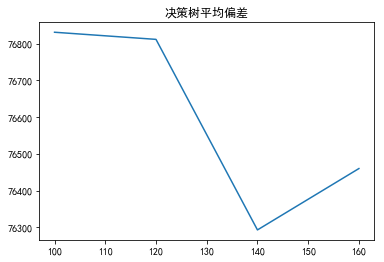

In [7]:
from sklearn.ensemble import AdaBoostRegressor
ada_params = [100,120,140,160]
ada_scores = []
for para in ada_params:
    clf = AdaBoostRegressor(n_estimators = par,base_estimator =  XGBRegressor(max_depth=6))
    test_score = -cross_val_score(clf,X_input,y,scoring = 'neg_mean_absolute_error',cv = 10)
    ada_scores.append(np.mean(test_score))
plt.plot(ada_params, ada_scores)
plt.title("决策树平均偏差")

# GBDT 

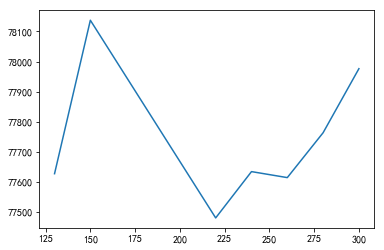

In [8]:
from sklearn.ensemble import GradientBoostingRegressor
params = [130,150,220,240,260,280,300]
scores = []
for para in params:
    clf=GradientBoostingRegressor(n_estimators = para)
    test_score = -cross_val_score(clf,X_input,y,cv = 10,scoring = 'neg_mean_absolute_error')
    scores.append(np.mean(test_score))
plt.plot(params,scores)
plt.rcParams['figure.figsize'] = (10,6)

#  测试集 的预测值和真实值比较 

In [524]:
X_train,X_test,y_train,y_test = train_test_split(X_input,y,test_size = 0.06,random_state = 0)

In [548]:
np.arange(10,20,2)

array([10, 12, 14, 16, 18])

# XGBOOst

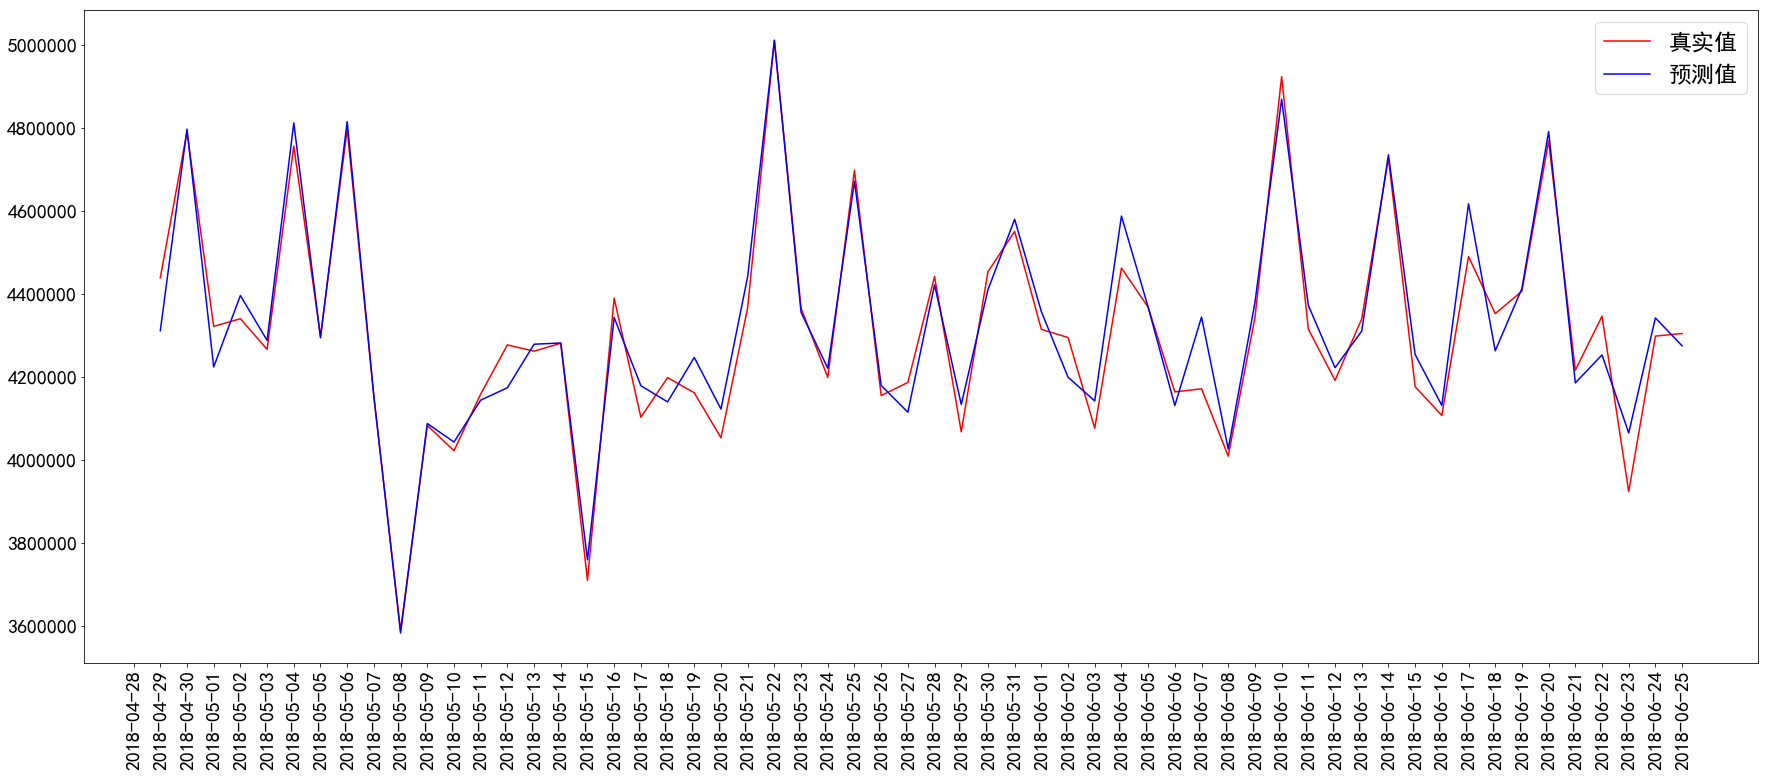

In [605]:
clf = xgb.XGBRegressor(colsample_bytree = 0.9,gamma = 0.1,learining_rate = 0.07, max_depth = 6, min_child_weight= 4,n_estimators=110,reg_alpha = 0.1,reg_lambda = 2,subsample = 0.7)
bag_reg = BaggingRegressor(n_estimators = 30,base_estimator = clf)
bag_reg.fit(X_train,y_train)
y_new_pre = bag_reg.predict(X_test)
#plt.rcParams['figure.figsize'] = (30,12)
fig1 = plt.figure(figsize=(30,12))
ax1 = fig1.add_subplot(1,1,1) # 一行一列第一块
ax1.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m-%d'))#设置时间标签显示格式
plt.xticks(pd.date_range('2018-04-28','2018-06-25'),rotation = 90)
plt.plot(date[-len(X_test):],y_test.values,'r-',label = '真实值')
plt.plot(date[-len(X_test):],y_new_pre,'b',label = '预测值')
plt.tick_params(labelsize=20)
plt.legend(prop={'size':23}) 

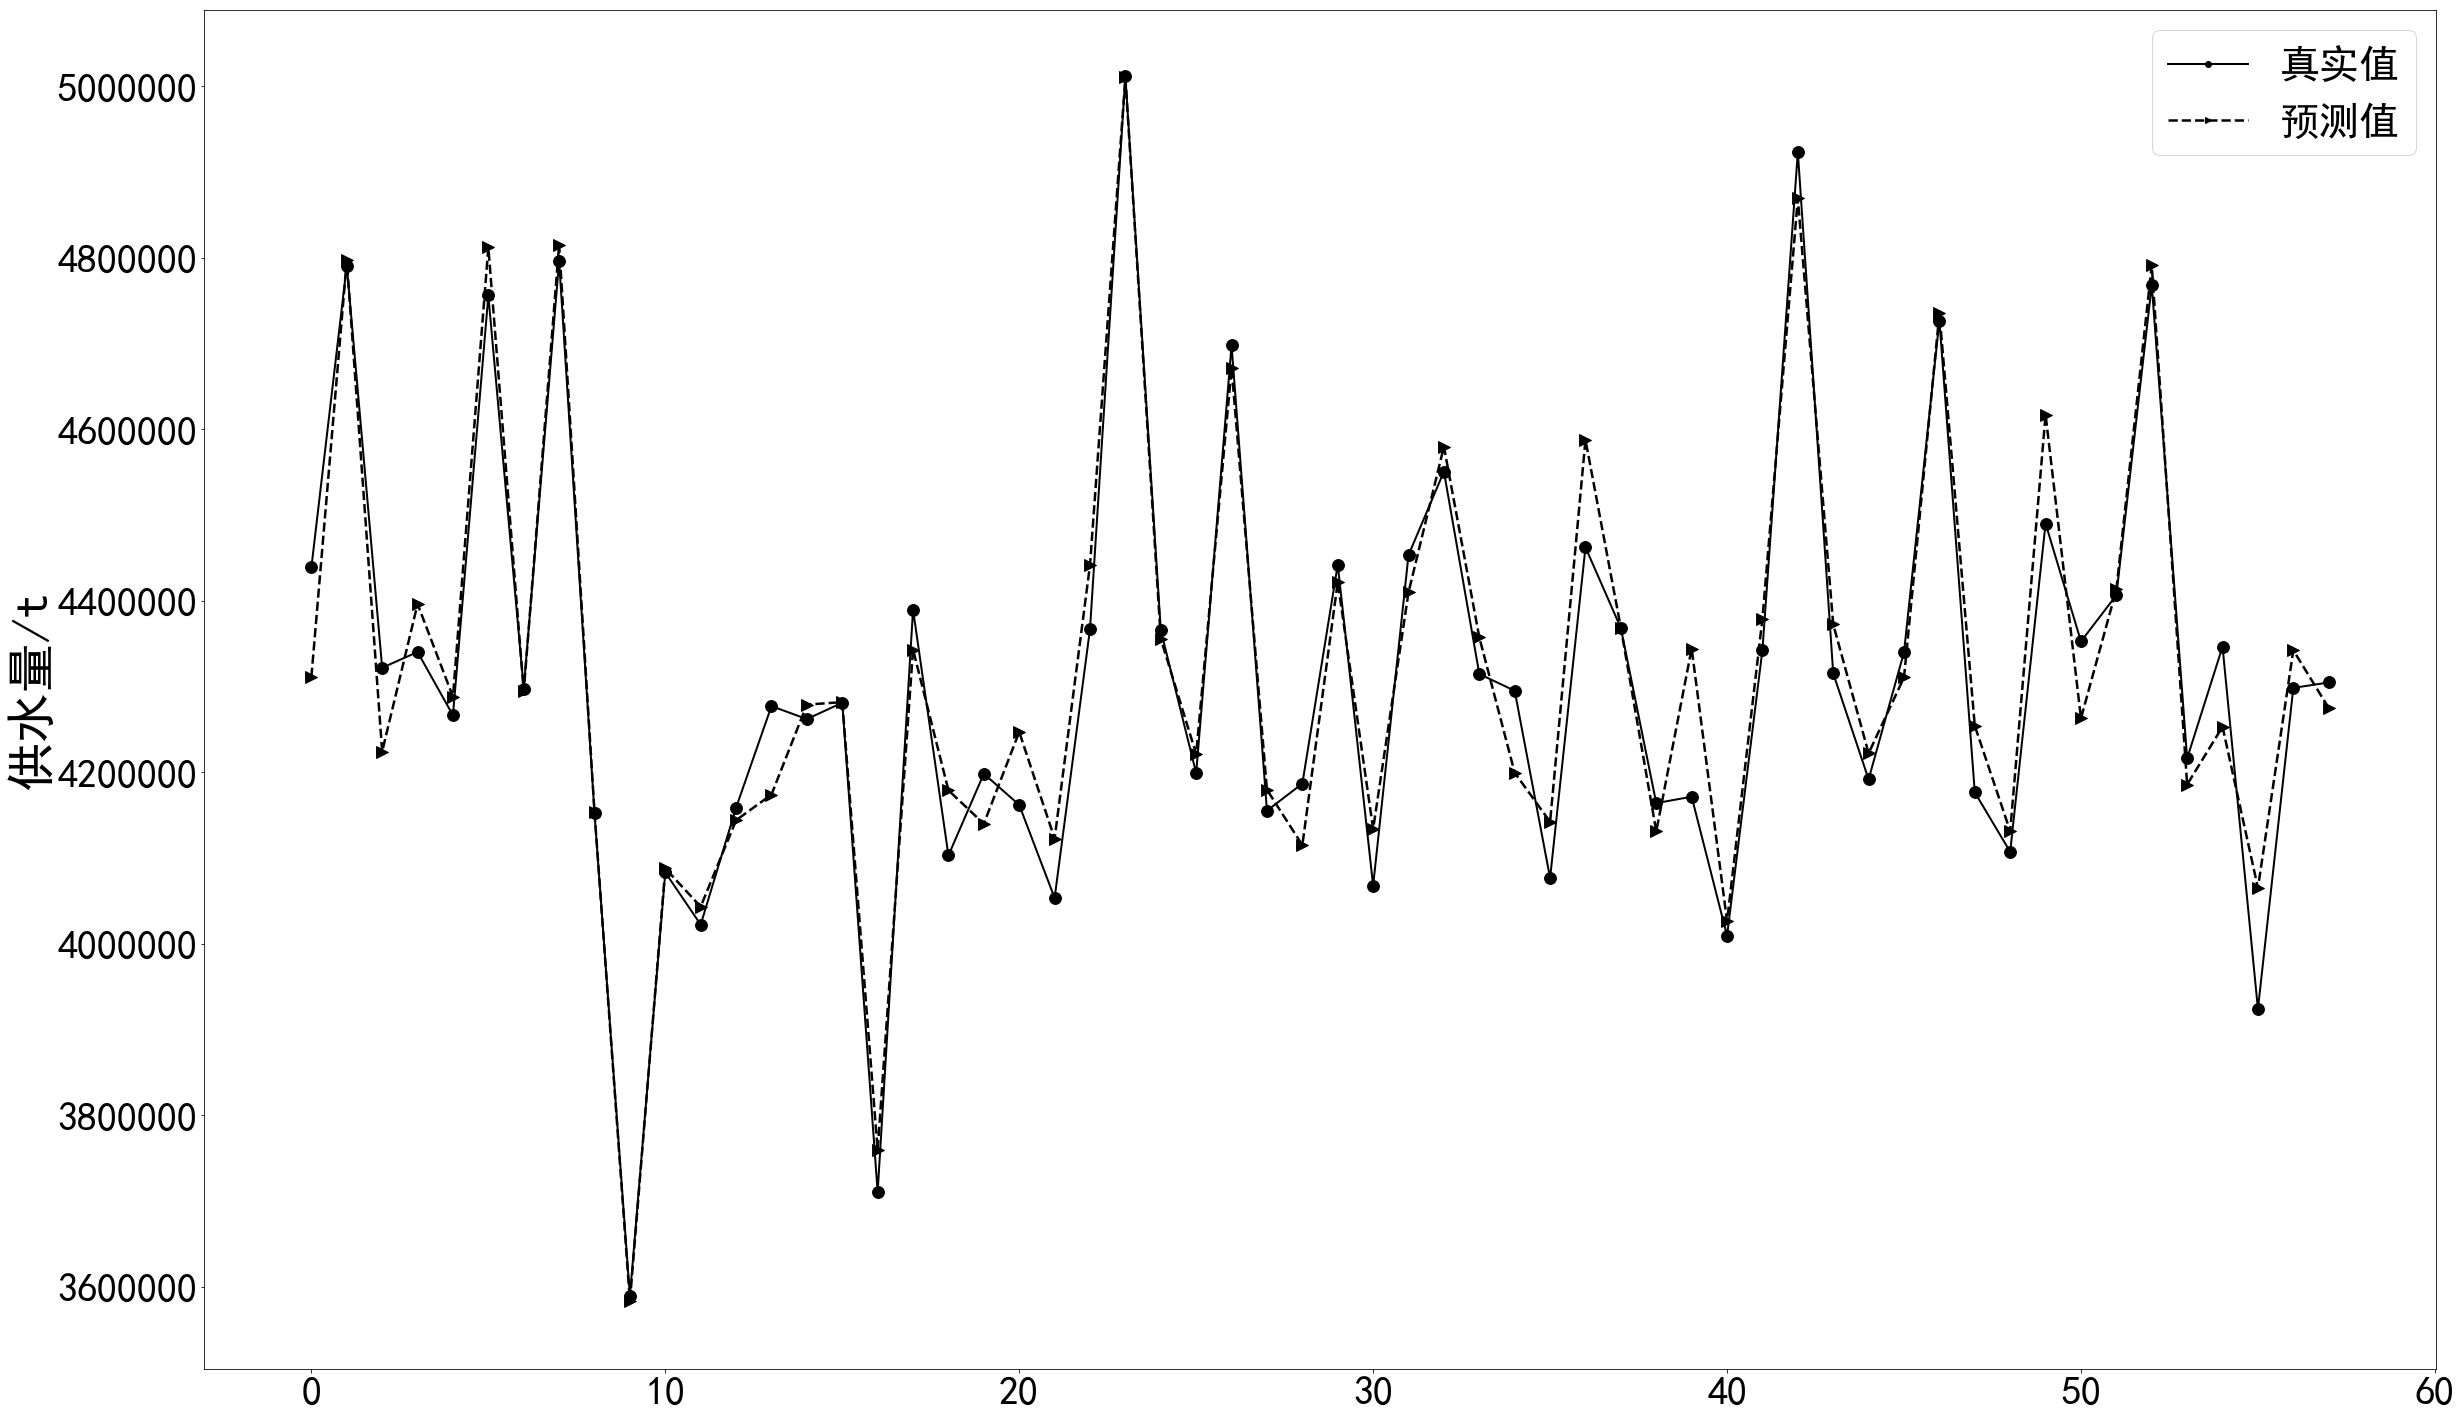

In [613]:
fig1 = plt.figure(figsize=(40,25))
ax1 = fig1.add_subplot(111)
ax1.scatter(range(len(X_test)),y_test.values,s= 140,color = 'black',marker = 'o')
ax1.plot(range(len(X_test)),y_test.values,'o-',color = 'black',label = '真实值',linewidth = 2)
ax1.scatter(range(len(X_test)),y_new_pre,s= 140,color = 'black',marker = '>')
ax1.plot(range(len(X_test)),y_new_pre,'>--',color = 'black',label = '预测值',linewidth = 2.5)
plt.ylabel('供水量/t',size = 50)
plt.tick_params(labelsize=40)
plt.legend(prop={'size':40}) 

In [607]:
print(np.mean(abs(y_test.values  - y_new_pre)))
print(np.mean(abs(y_test.values - y_new_pre)/y_test.values))

48003.66379310345
0.011230220023475339


# 决策树

In [614]:
def sorry(model):
    model.fit(X_train,y_train)
    y_pre = model.predict(X_test)
    fig1 = plt.figure(figsize=(40,25))
    plt.scatter(range(len(X_test)),y_test.values,s= 140,color = 'black',marker = 'o')
    plt.scatter(range(len(X_test)),y_new_pre,s= 140,color = 'black',marker = '>')
    plt.plot(range(len(X_test)),y_test.values,'o-',color = 'black',label = '真实值',linewidth = 2)
    plt.plot(range(len(X_test)),y_new_pre,'>--',%colors = 'black',label = '预测值',linewidth = 2.5)
    plt.tick_params(labelsize=40)
    plt.ylabel('供水量/t',size = 50)
    plt.legend(prop={'size':40}) 
    print(np.mean(abs(y_test-y_pre)))
    print(np.mean(abs(y_test - y_pre)/y_test))

83748.8275862069
0.019563317007283164


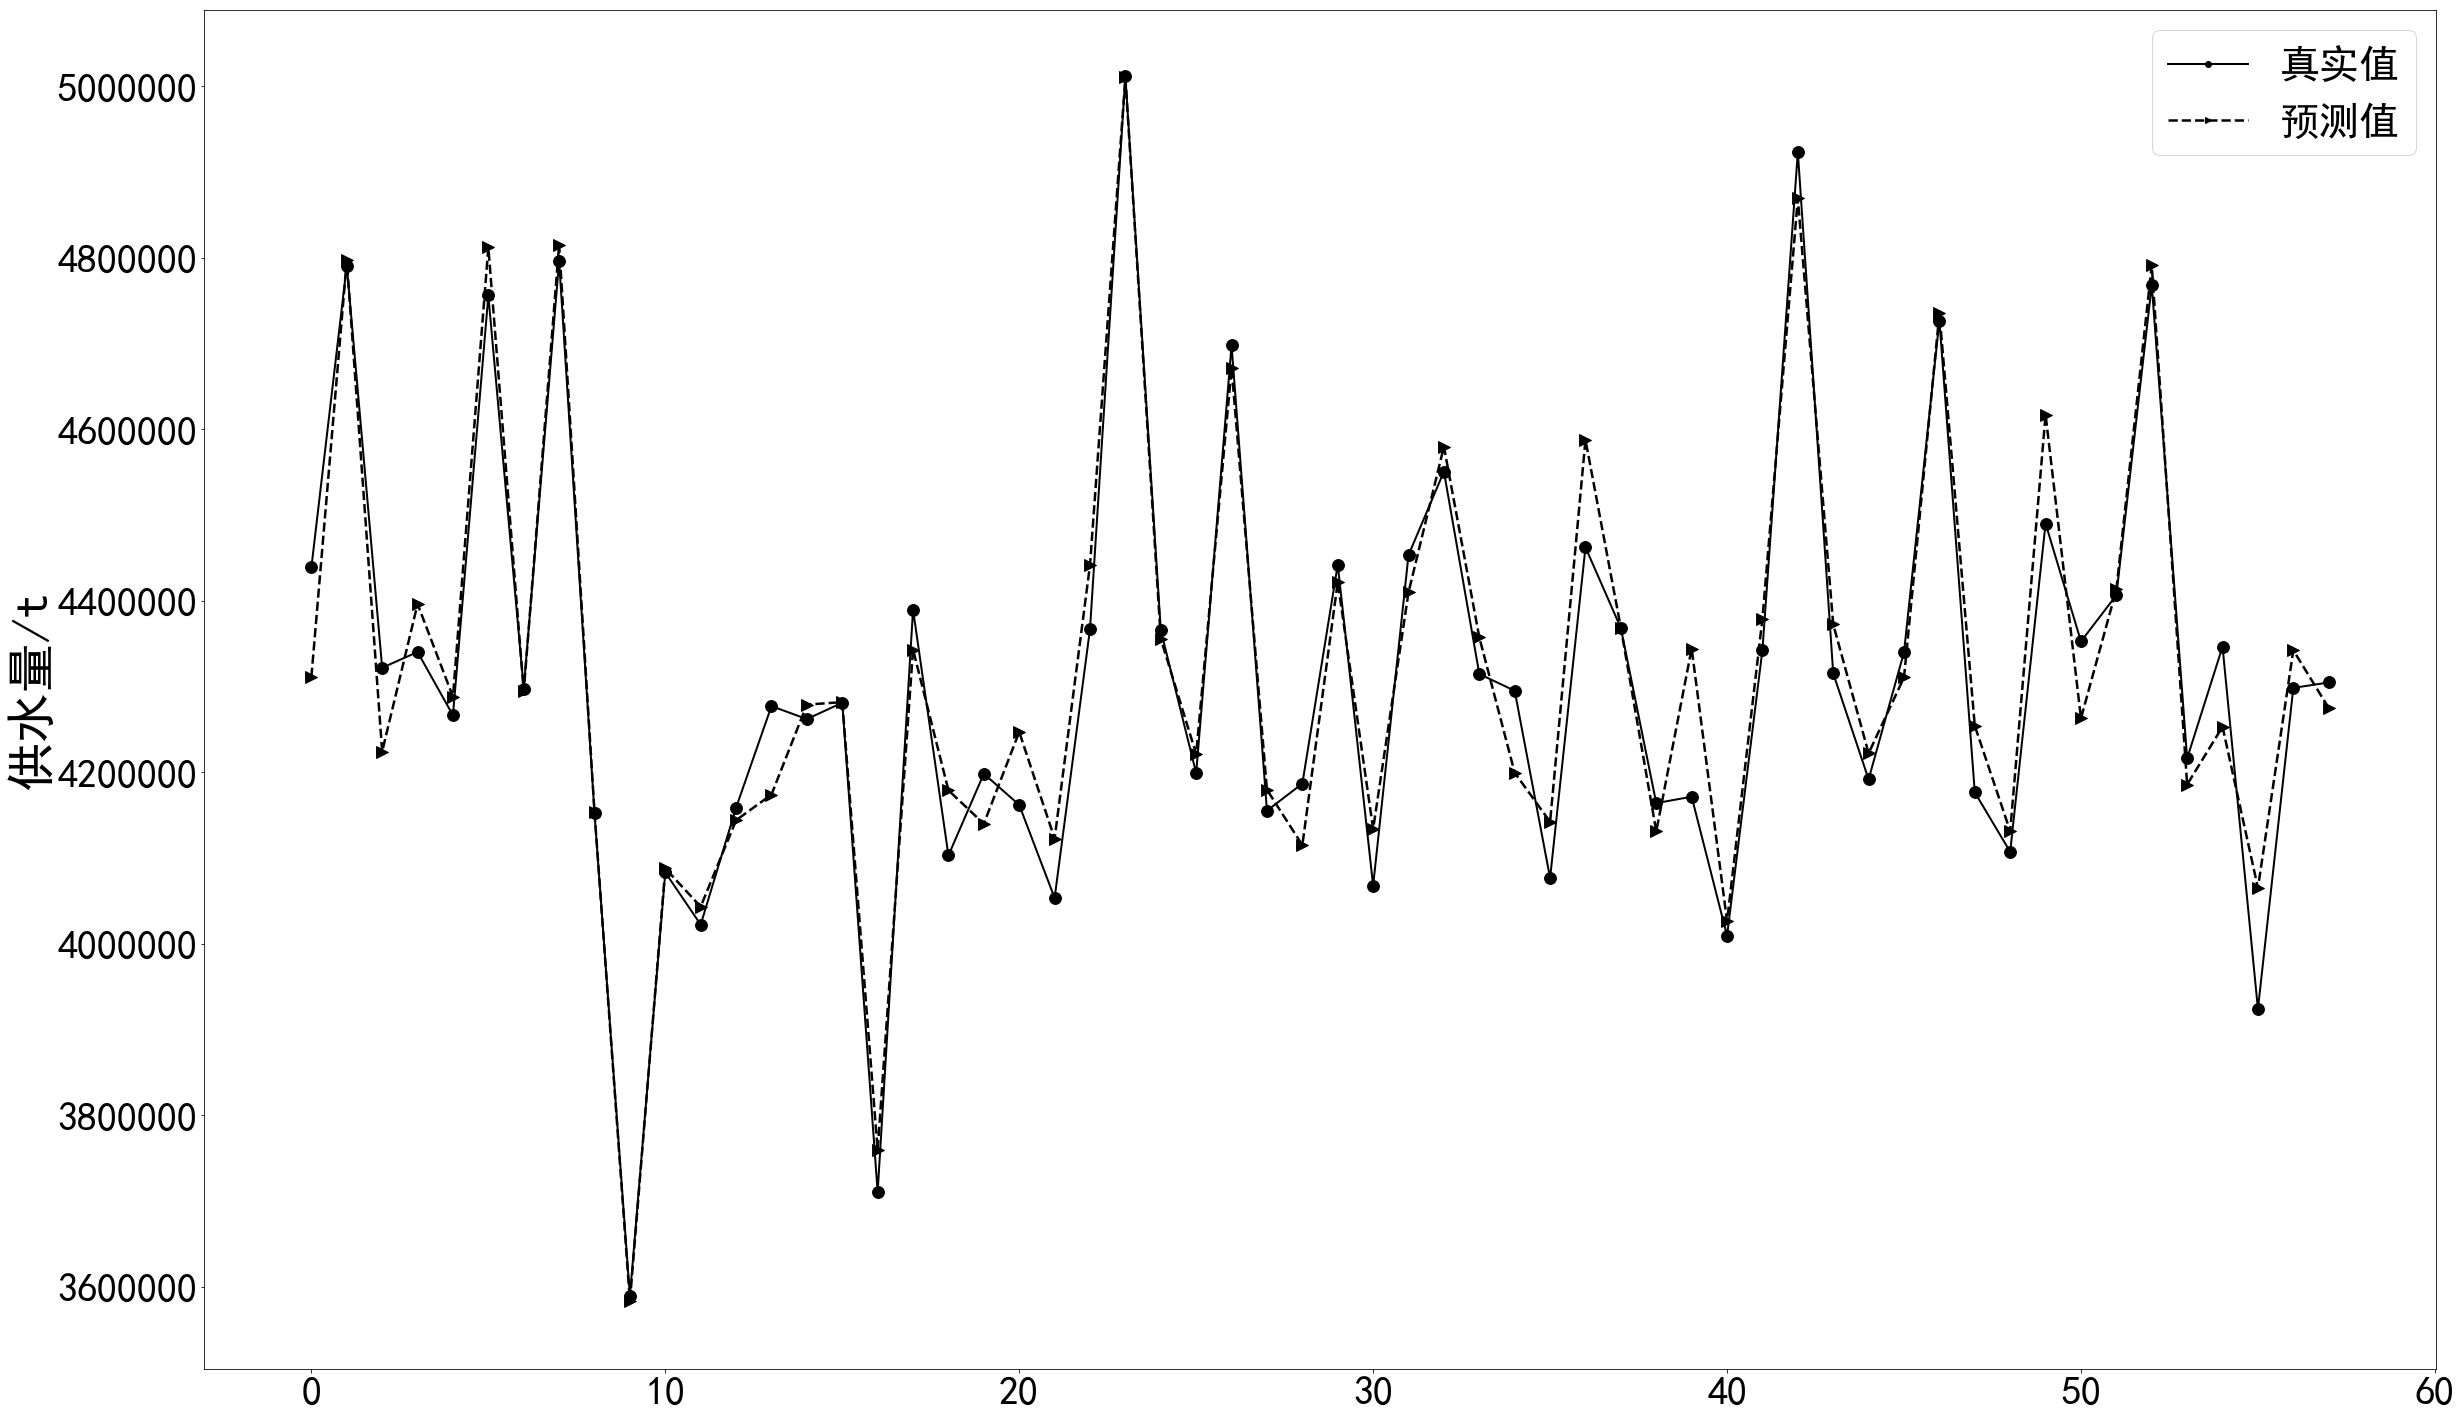

In [615]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
sorry(DecisionTreeRegressor())

# 随机森林

68020.98620689657
0.015849274727951213


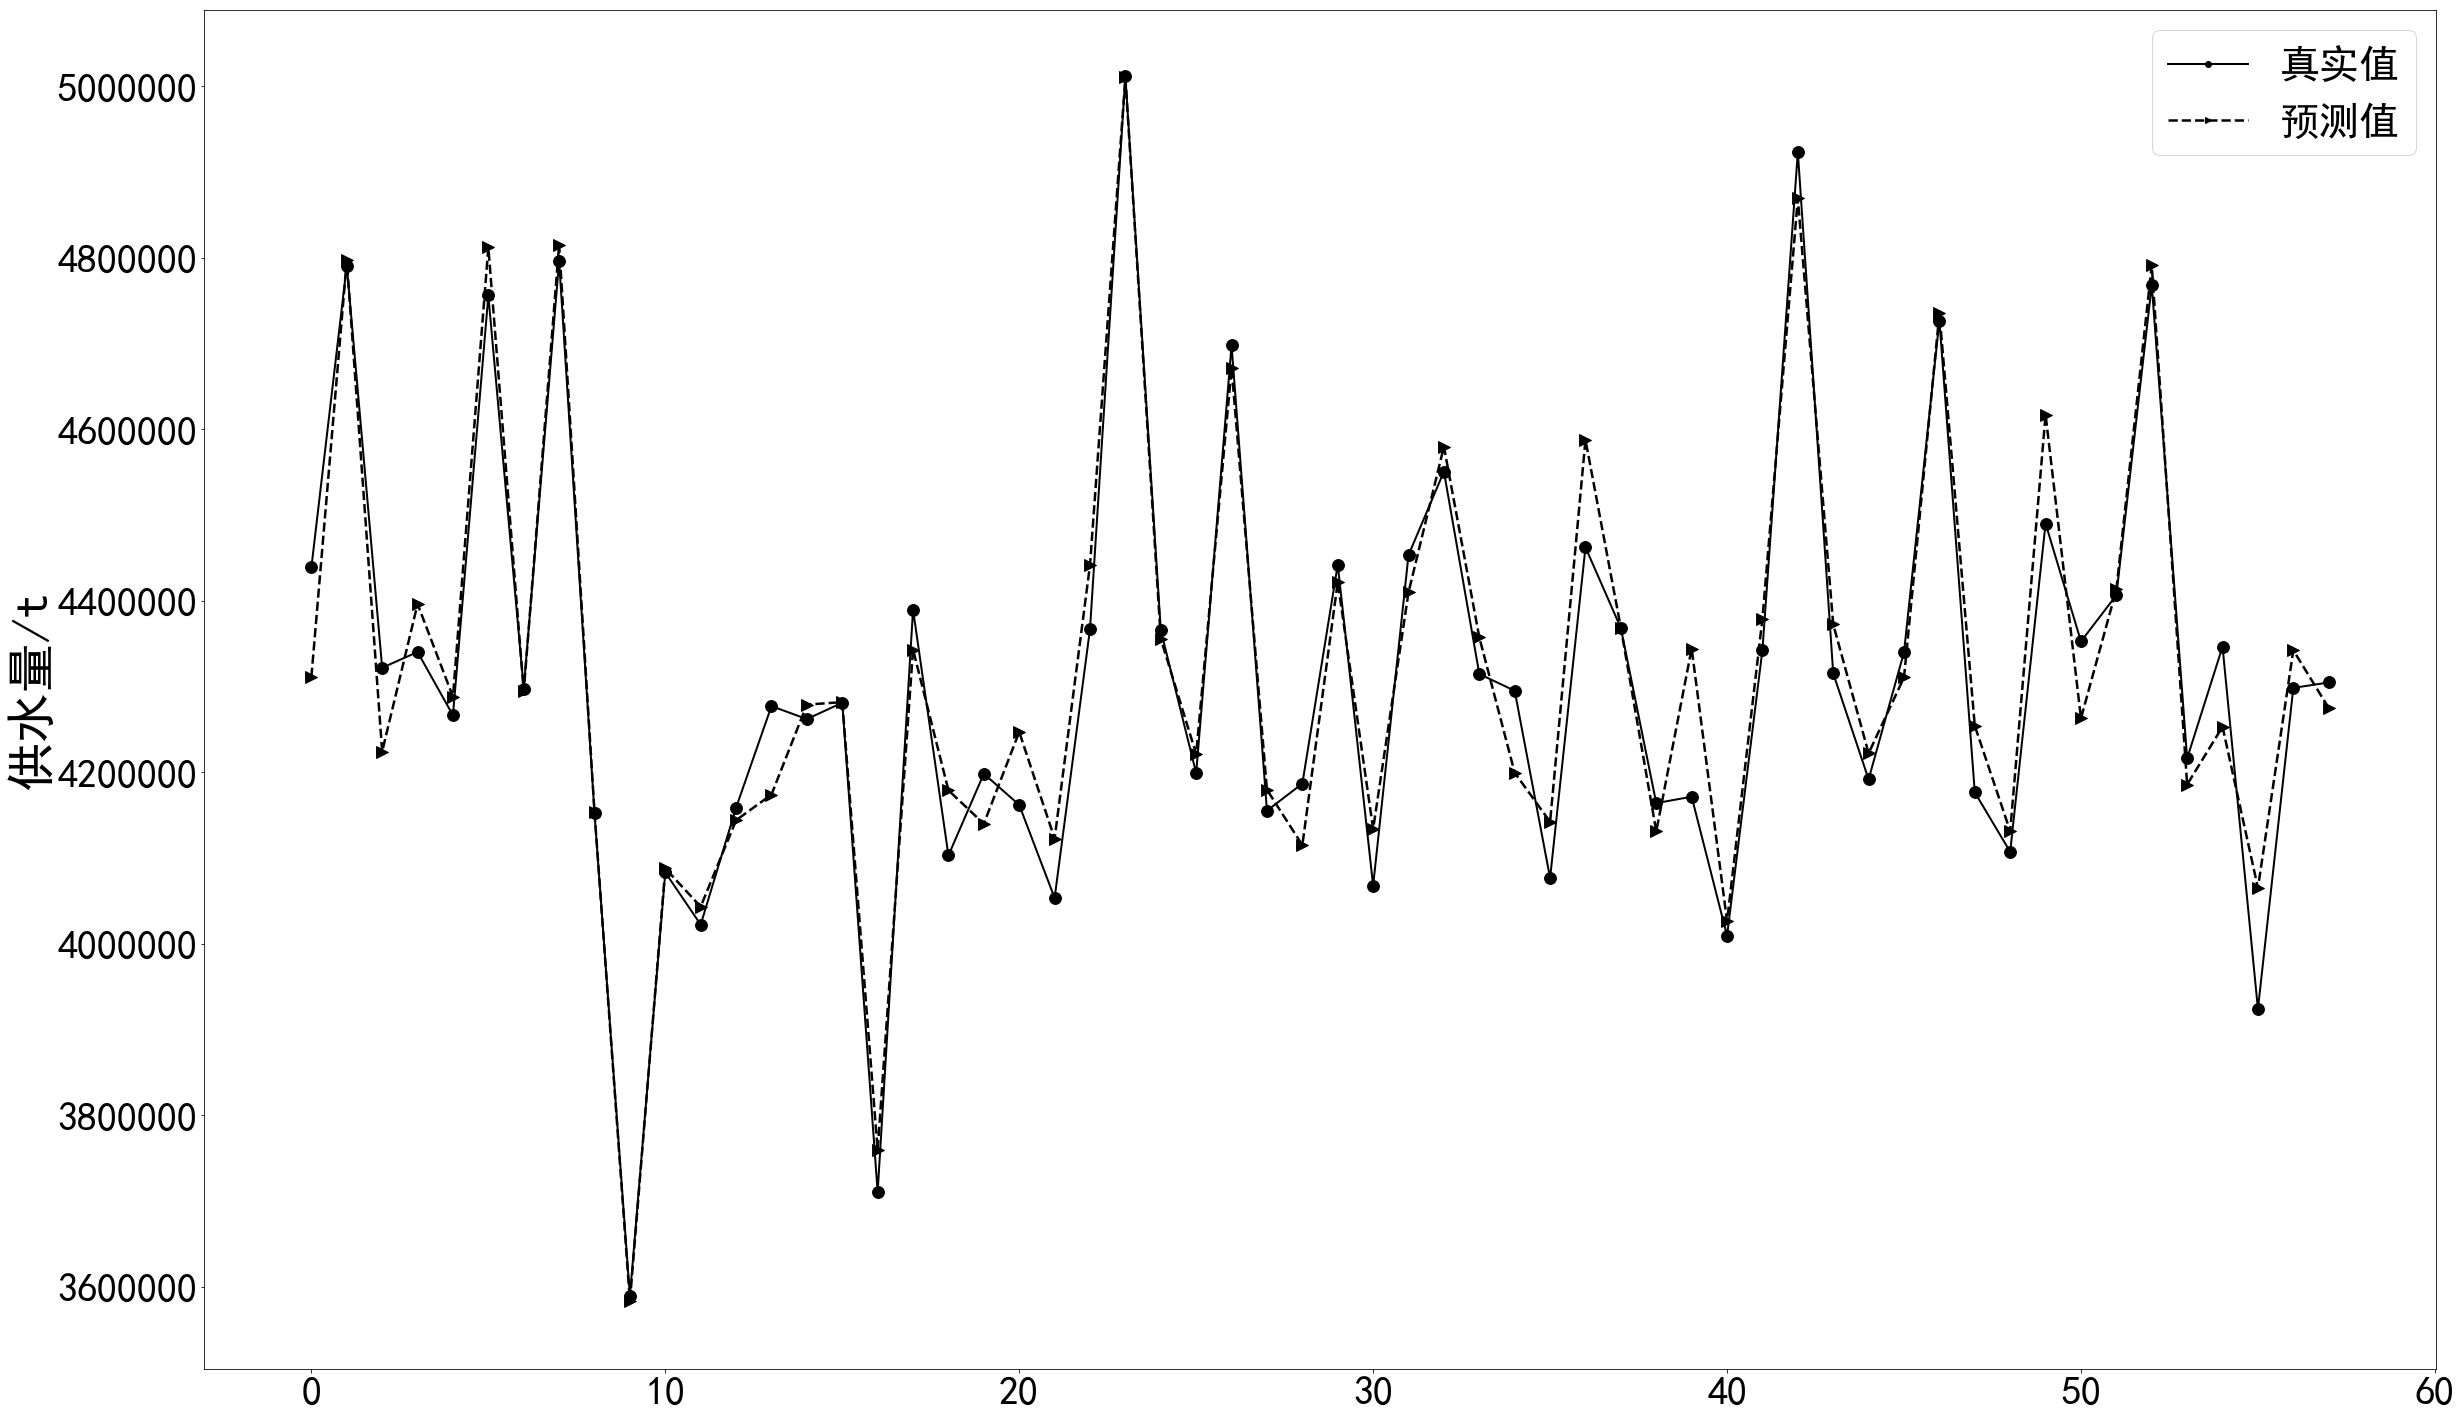

In [616]:
sorry(RandomForestRegressor())

# SVR

c:\python3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.
c:\python3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
c:\python3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


58759.54433242537
0.013846737433360474


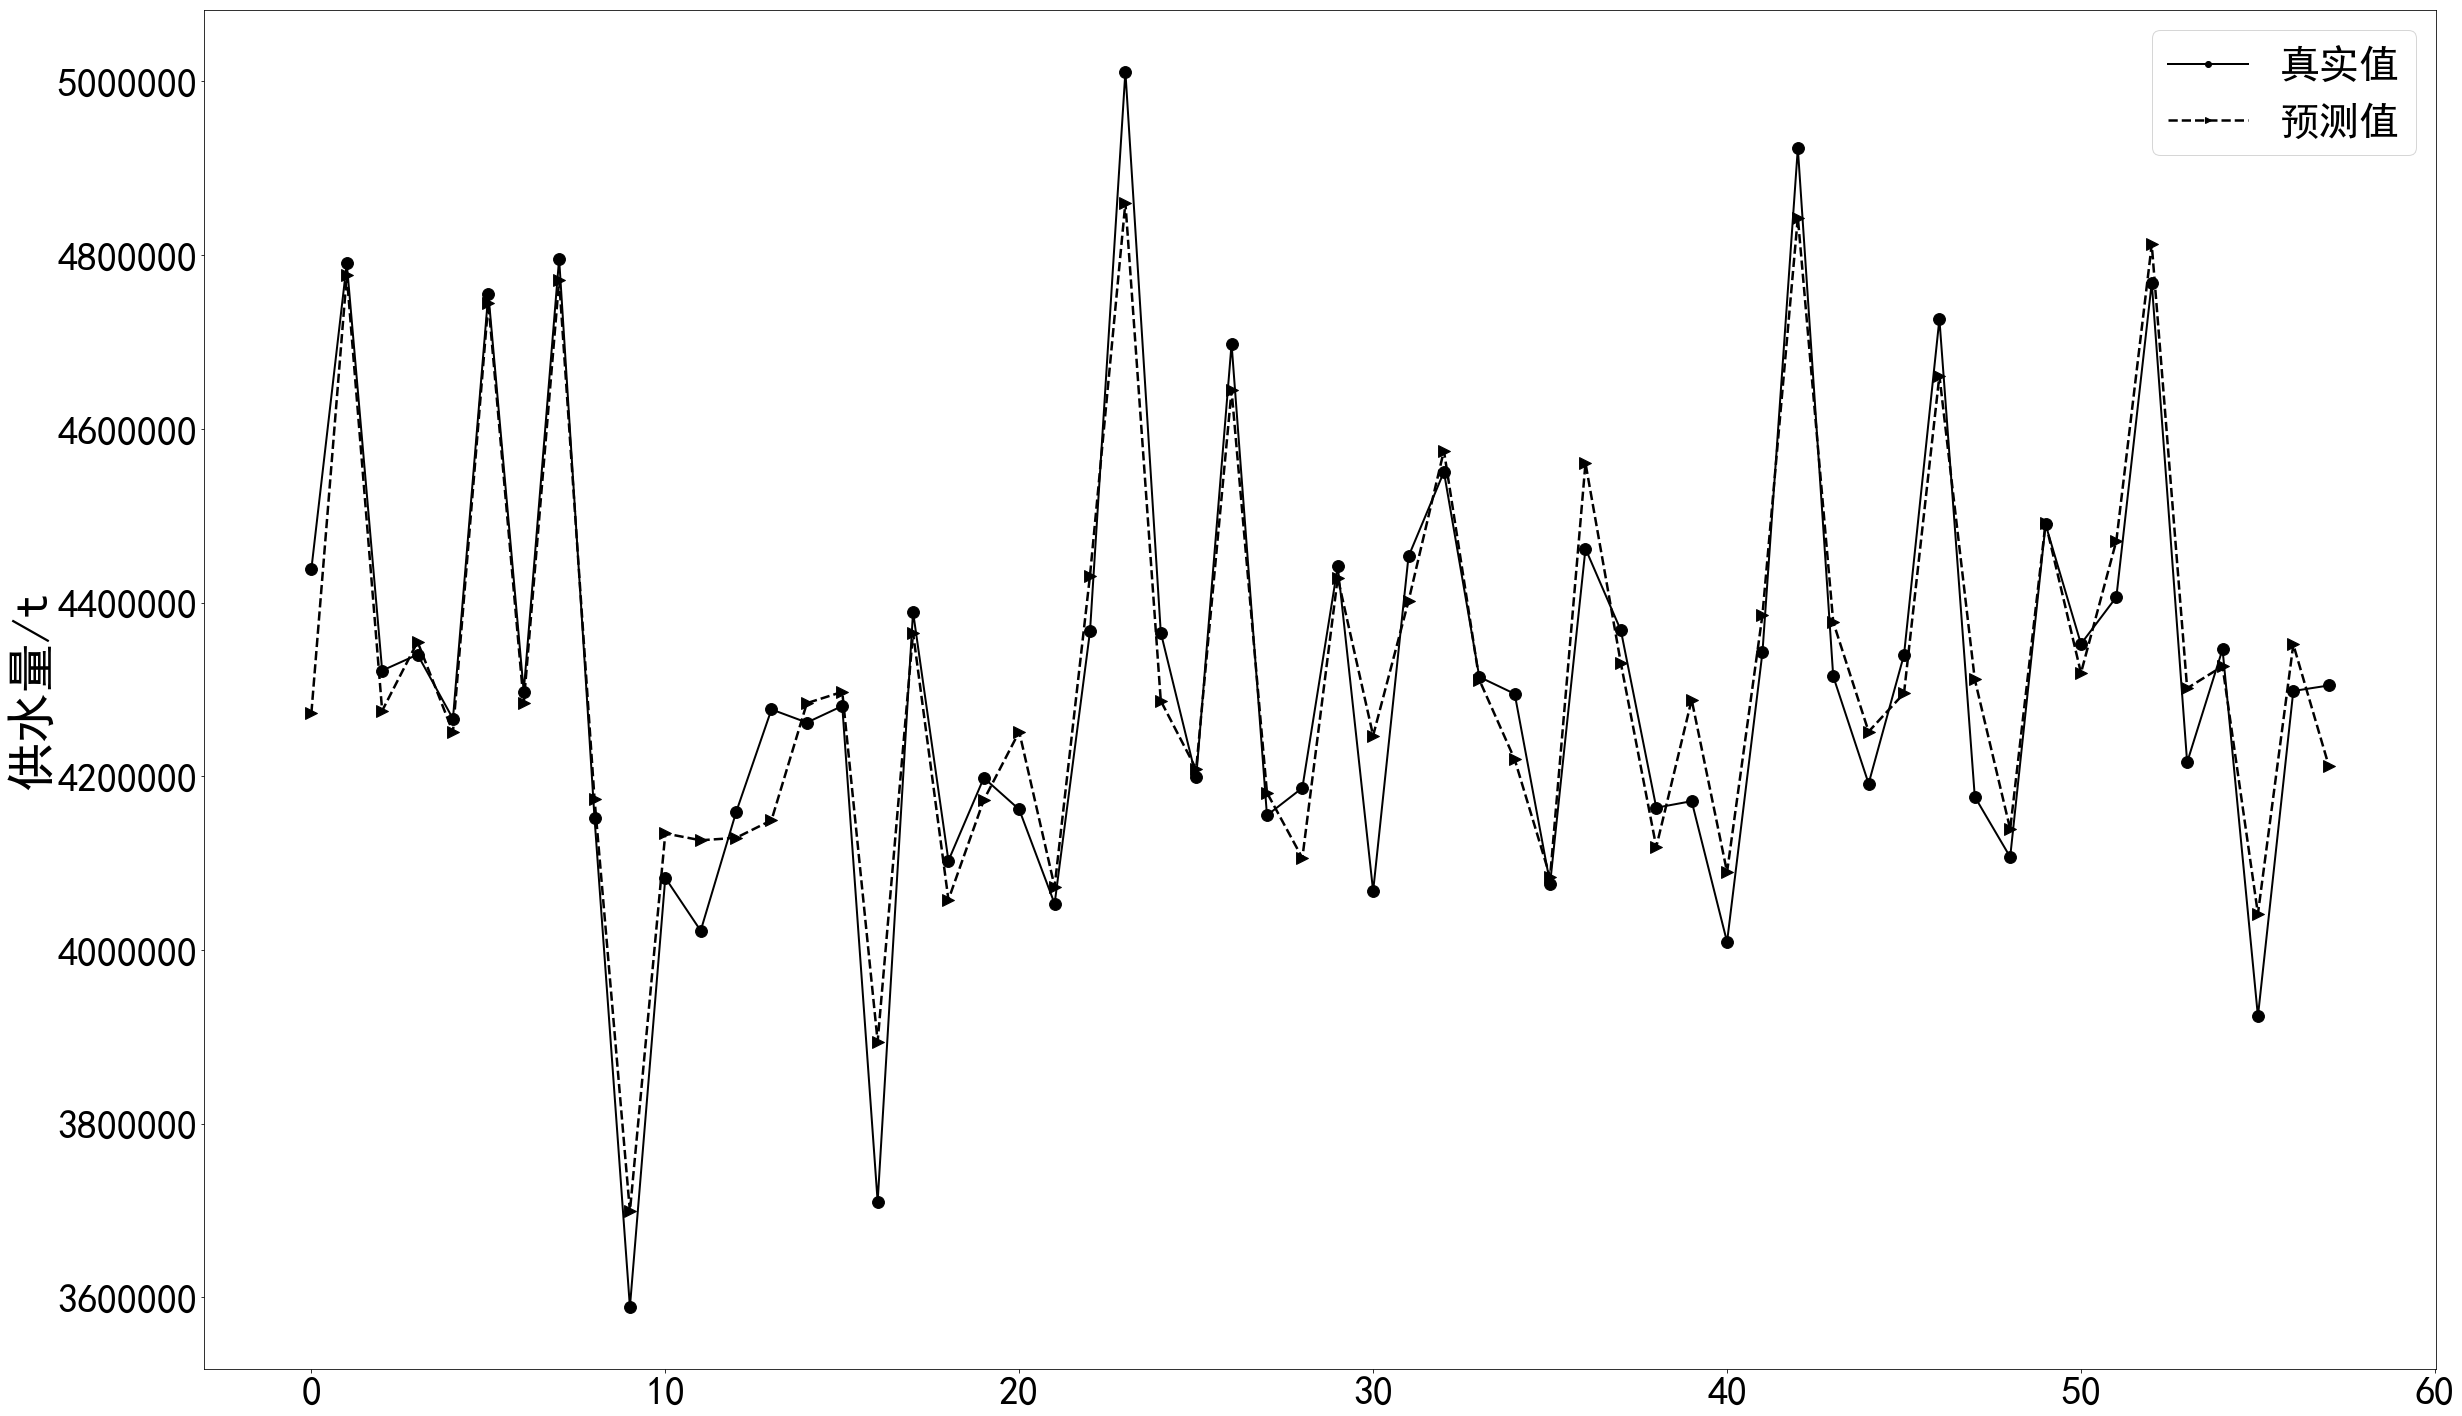

In [617]:
x_chart = StandardScaler()
y_chart = StandardScaler()
x_scaler = x_chart.fit_transform(pd.concat([X_train,X_test],axis = 0))
y_scaler = y_chart.fit_transform(y_train.reshape(-1,1))                                               
clf = SVR()
clf.fit(x_scaler[:len(X_train)],y_scaler)
y_pre = clf.predict(x_scaler[-len(X_test):])
plt.rcParams['figure.figsize'] = (40,25)
y_pre = y_chart.inverse_transform(y_pre)

plt.scatter(range(len(X_test)),y_test.values,s= 140,color = 'black',marker = 'o')
plt.scatter(range(len(X_test)),y_pre,s= 140,color = 'black',marker = '>')

plt.plot(range(len(X_test)),y_test,'o-',color = 'black',label = '真实值',linewidth = 2)
plt.plot(range(len(X_test)),y_pre,'>--',color = 'black',label = '预测值',linewidth = 2.5)
plt.tick_params(labelsize=40)
plt.ylabel('供水量/t',size = 50)
plt.legend(prop={'size':40}) 
print(np.mean(abs(y_test-y_pre)))
print(np.mean(abs(y_test-y_pre)/y_test))

# BP神经网络

In [618]:
import tensorflow as tf
inunits =  89
h1_units = 15
W1 = tf.Variable(tf.random_normal([inunits,h1_units],stddev = 0.1),name = 'w1')
b1 = tf.Variable(tf.zeros([h1_units]),name = 'b1')
W2 = tf.Variable(tf.zeros([h1_units,1]),name = 'w2')
b2 = tf.Variable(tf.zeros([1]),name = 'b2')

In [619]:
X = tf.placeholder(tf.float32,[None,inunits],name = 'X')
Y = tf.placeholder(tf.float32,[None,1],name = 'Y')
hidden1 = tf.matmul(X,W1) + b1
y_p = tf.matmul(hidden1,W2) + b2
loss = tf.reduce_mean(tf.reduce_sum(tf.abs(Y - y_p),reduction_indices=[1]))
train_step = tf.train.AdagradOptimizer(0.01).minimize(loss)
init=tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
for i in range(100000):
    _,l = sess.run([train_step,loss],feed_dict={X:X_train.values,Y:y_train.values.reshape(-1,1)})

In [620]:
y_pre = sess.run(y_p,feed_dict={X:X_test})

84221.47844827586
0.019855750714553037


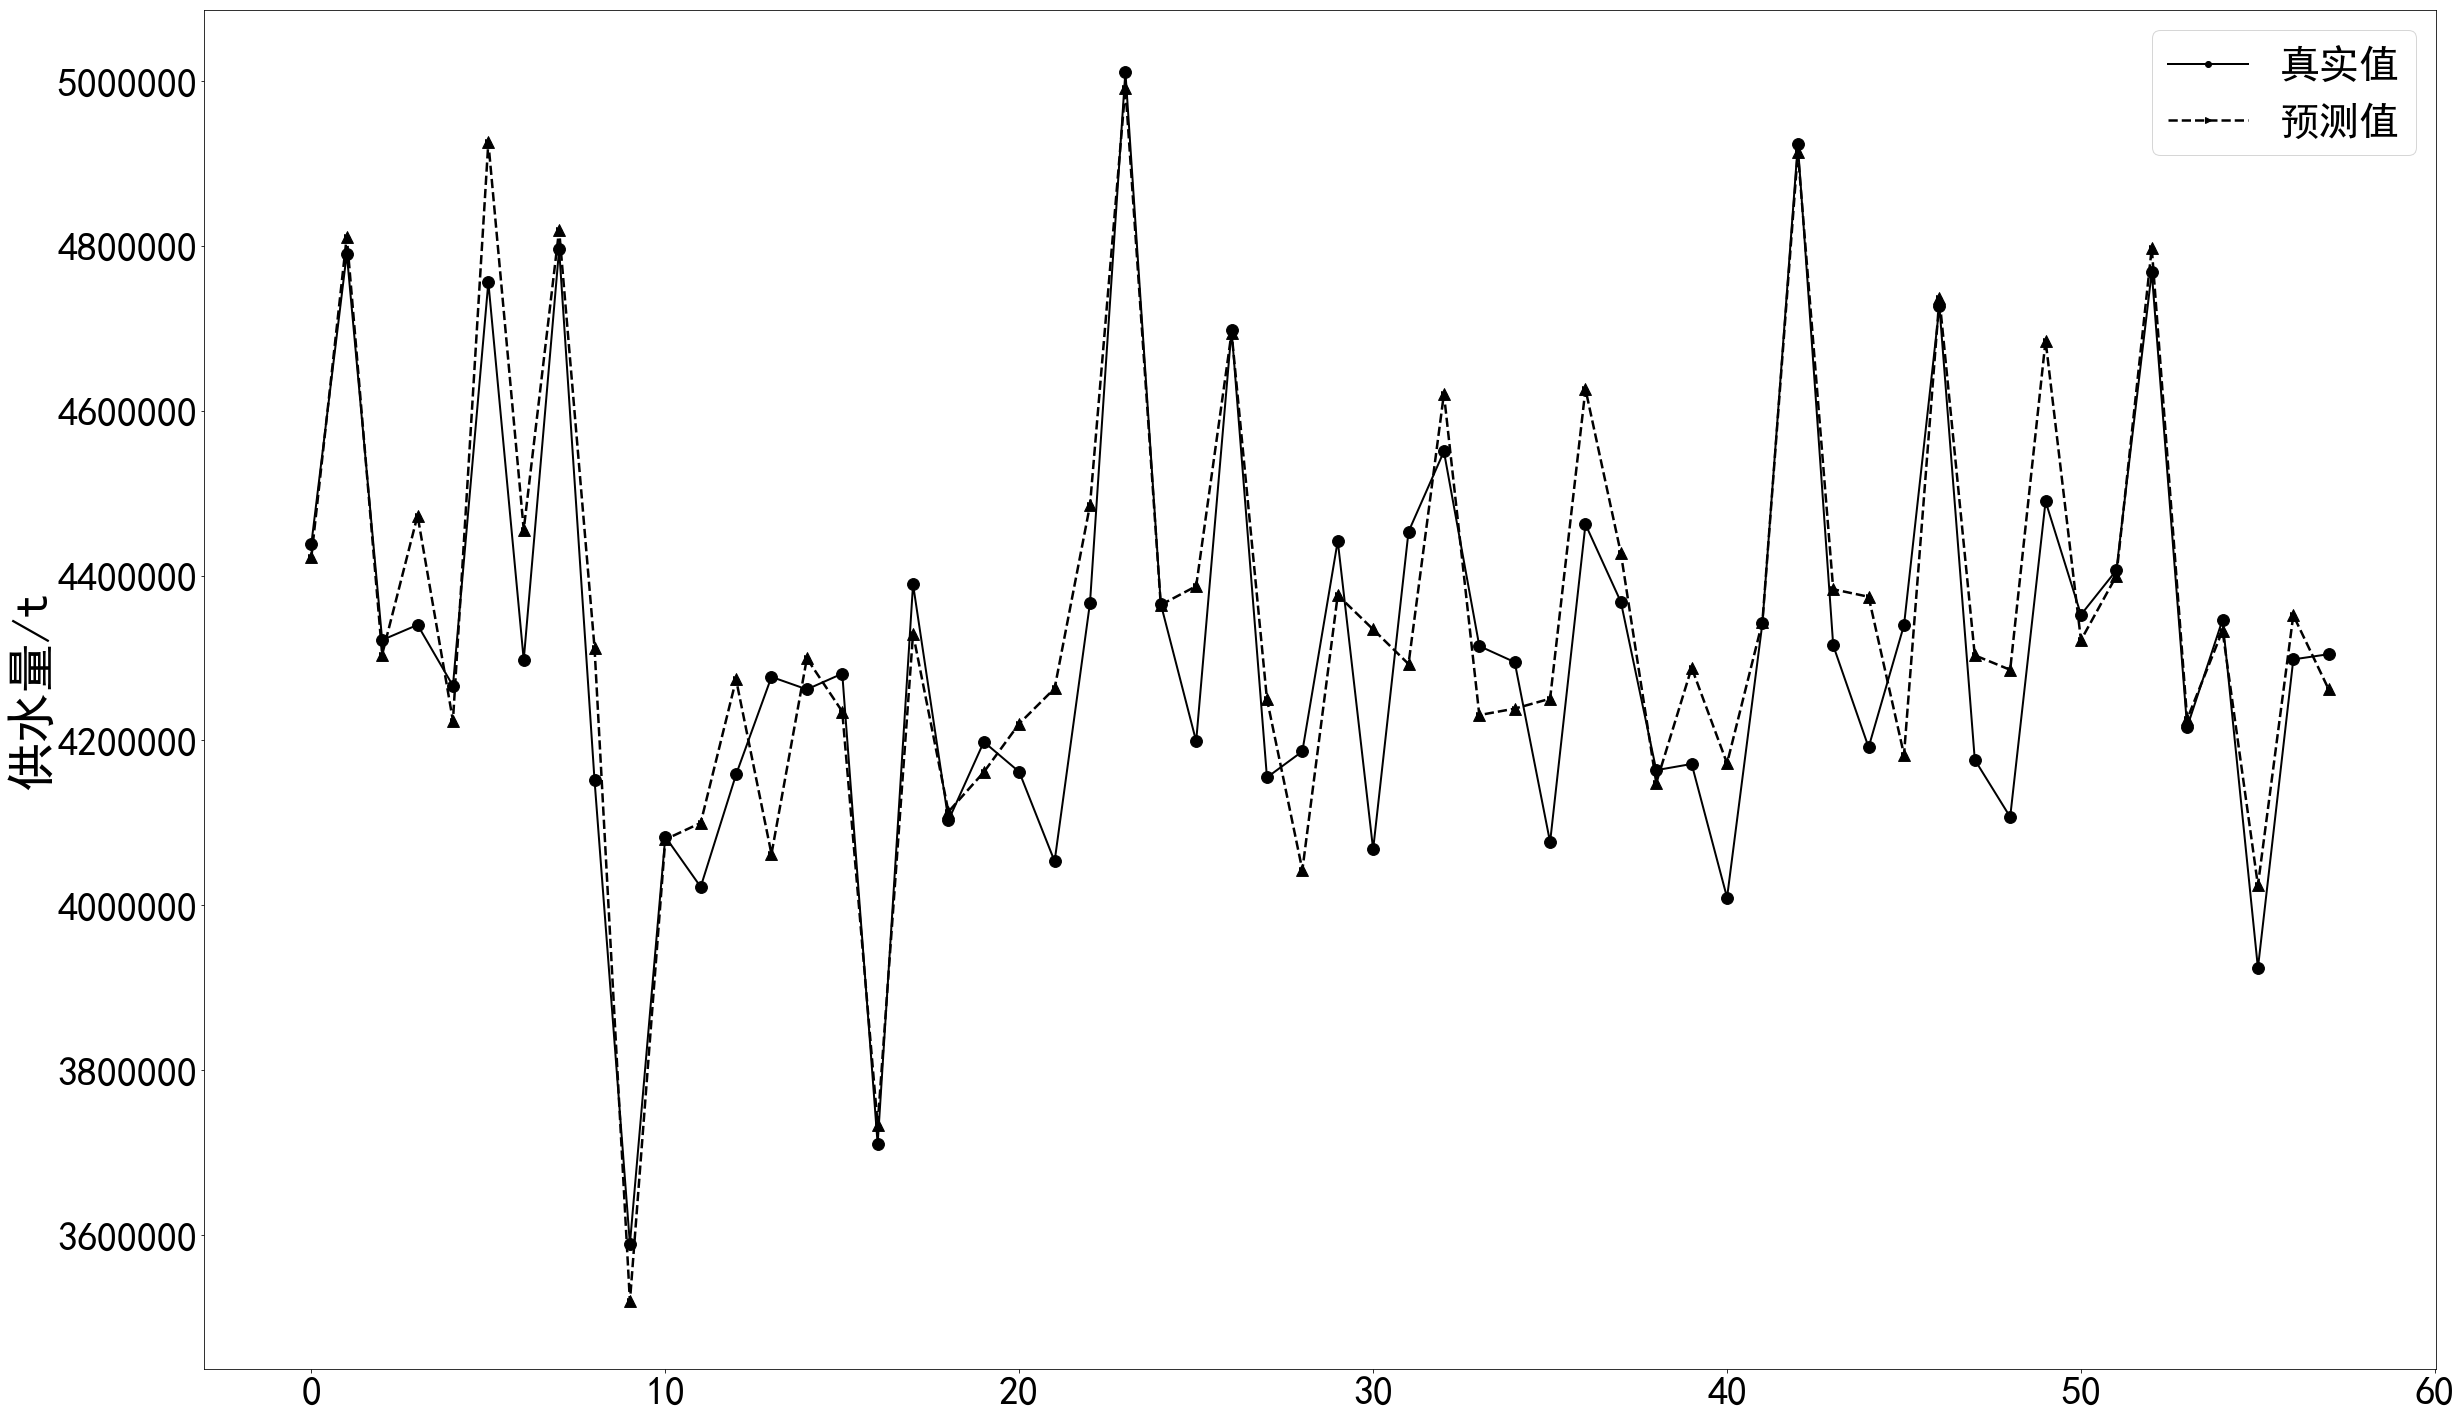

In [621]:
fig1 = plt.figure(figsize=(40,25))
plt.scatter(range(len(X_test)),y_test.values,s= 140,color = 'black',marker = 'o')
plt.scatter(range(len(X_test)),y_pre,s= 140,color = 'black',marker = '^')

plt.plot(range(len(X_test)),y_test,'o-',color = 'black',label = '真实值',linewidth = 2)
plt.plot(range(len(X_test)),y_pre,'>--',color = 'black',label = '预测值',linewidth = 2.5)
plt.tick_params(labelsize=40)
plt.legend(prop={'size':40}) 
plt.ylabel('供水量/t',size = 50)
print(np.mean(abs(y_test-y_pre.reshape(-1))))
print(np.mean(abs(y_test-y_pre.reshape(-1))/y_test))

## 由上图可得BaggingRegressor(n_estimators = 60,base_estimator =  XGBRegressor(max_depth=6))效果最好

## 预测新值传入格式为excel 

In [104]:
X_new = pd.DataFrame(columns = X_test.columns)
excel = pd.read_excel('./每日自变量输入.xlsx')
for i in range(len(excel.index)):
    X_new.loc[i] = 0
X_new['dayofyear'] = excel['日期'].apply(lambda x:x.dayofyear)
X_new['year'] = excel['日期'].apply(lambda x:x.year)
X_new['dayofweek'] = excel['日期'].apply(lambda x:x.dayofweek)
X_new['dayofmonth'] = excel['日期'].apply(lambda x:x.day)
excel.drop('日期',axis = 1,inplace = True)
for j in excel.index:
    for i in excel.columns:
        if i in X_new.columns:
            X_new.loc[j,i] = excel.iloc[j][i]
        else:
            str_1 = i + '_' + excel.iloc[j][i].strip()
            X_new.loc[j,str_1] = 1
#X_read = pd.read_excel('./input4.xlsx')
#X_new[['前一天供水量','再往前一天供水量']] = np.mean(X_read[(X_read['日期']>='2018-4-25')&(X_read['日期']<='2018-5-2')]['总供水量'])

## 预测新值

In [108]:
bag_reg = BaggingRegressor(n_estimators = 30,base_estimator =  xgb.XGBRegressor(colsample_bytree = 0.9,gamma = 0.1,
    learining_rate = 0.07,max_depth = 6, min_child_weight= 4,n_estimators=110,reg_alpha = 0.1,reg_lambda = 2,subsample = 0.7)
bag_reg.fit(X_input,y)
y_new_pre = bag_reg.predict(X_new)

## 保存模型 

In [110]:
from sklearn.externals import joblib
bag_reg = BaggingRegressor(n_estimators = 60,base_estimator =  XGBRegressor(max_depth=6)) 
bag_reg.fit(X_input,y) #训练模型参数
joblib.dump(bag_reg, 'model.pkl') #将模型训练结果保存到model.pkl中

['model.pkl']

In [646]:
def train_cross(model,X,Y):
    test_score = -cross_val_score(model, X, Y, cv=10, scoring='neg_mean_absolute_error')
    print(np.mean(test_score))
def MRE(model,X,Y):
    X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size = 0.2)
    model.fit(X_train,y_train)
    pre = model.predict(X_test)
    print(np.mean(abs(pre-y_test)/y_test))
def Predict(model,X_train,Y_train,X_test,Y_test,day,date):
    model.fit(X_train,Y_train)
    y_pre = model.predict(X_test)
    #plt.rcParams['figure.figsize'] = (20,12)
    #plt.rcParams['figure.figsize'] = (20,12)
    fig1 = plt.figure(figsize=(20,12))
    ax1 = fig1.add_subplot(1,1,1)
    ax1.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m-%d'))#设置时间标签显示格式
    #plt.ylim((4000000, 4600000))
    #plt.xticks(pd.date_range('2018-02-25','2018-06-25'),rotation = 45)
    
    plt.plot(date,Y_test.values,'-ro',label = '真实值')
    plt.plot(date,y_pre,'-bs',label = '预测值')
    plt.tick_params(labelsize=20)
    plt.legend(prop={'size':23}) 
    print(np.mean(abs(Y_test-y_pre)))
    print(np.mean(abs(Y_test - y_pre)/Y_test))
def Predict_xgboost(model,X_train,Y_train,X_test,Y_test,day,date):
    model.fit(X_train,Y_train)
    y_pre = model.predict(X_test)
    #y_pre[9] = y_pre[9] + 50000
    #y_pre[11] = y_pre[11] - 40000
    #y_pre[12] = y_pre[12] - 40000
    #plt.rcParams['figure.figsize'] = (20,12)
    fig1 = plt.figure(figsize=(20,12))
    ax1 = fig1.add_subplot(1,1,1)
    ax1.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m-%d'))#设置时间标签显示格式
    #plt.xticks(pd.date_range('2014-09-01','2014-09-30'),rotation=90)
    #plt.ylim((4000000, 4600000))
    #plt.xticks(pd.date_range('2018-06-01','2018-06-25'),rotation = 45)
    plt.plot(date,Y_test.values,'-ro',label = '真实值')
    plt.plot(date,y_pre,'-b^',label = '预测值')
    plt.legend() 
    print(np.mean(abs(Y_test-y_pre)))
    print(np.mean(abs(Y_test - y_pre)/Y_test))

## 决策树预测

In [651]:
from sklearn.tree import DecisionTreeRegressor
clf = DecisionTreeRegressor()
train_cross(clf,X_input,y)
MRE(clf,X_input,y)

115737.4095790378
0.024474755926694024


117117.95172413794
0.0296988837037119


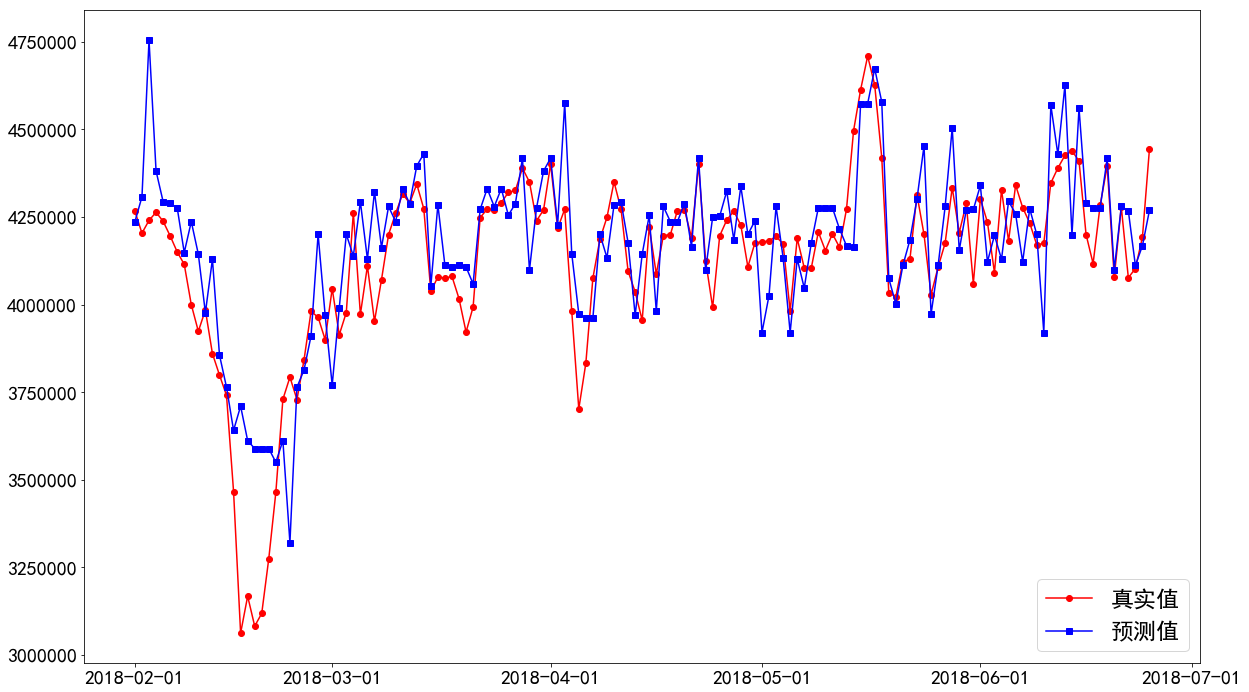

In [623]:
import matplotlib.dates as mdate
clf = DecisionTreeRegressor(random_state=2)
day = 145
Predict(clf,X_input[:-day],y[:-day],X_input[-day:],y[-day:],day,date[-day:])

## SVR回归预测

In [624]:
x_train, x_test, y_train, y_test = train_test_split(X_input, y, test_size=0.1, random_state=33)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.svm import SVR
from sklearn import preprocessing
ss_x = StandardScaler()
ss_y = StandardScaler()
x_train = ss_x.fit_transform(x_train)
x_test = ss_x.transform(x_test)
y_train = ss_y.fit_transform(y_train.reshape(-1, 1))
#y_test = ss_y.transform(y_test.reshape(-1, 1))
svr = SVR(kernel='poly')
svr.fit(x_train,y_train)
predict_value = ss_y.inverse_transform(svr.predict(x_test))
print(mean_absolute_error(predict_value,y_test))
print(np.mean(abs(predict_value-y_test)/y_test))

83848.57268782413
0.020195517158113848


c:\python3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # Remove the CWD from sys.path while we load stuff.
c:\python3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
c:\python3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [648]:
rf = RandomForestRegressor()
train_cross(rf,X_input,y)
MRE(rf,X_input,y)

84366.42228307562
0.017085556150241793


In [644]:
ss_y.inverse_transform(test_score)

array([4494579.96807023, 4426561.75432688, 4457221.46489965,
       4418173.28793201, 4423738.6413503 , 4400591.10950621,
       4391235.69253436, 4383036.59364069, 4425305.8512954 ,
       4412796.7956193 ])

c:\python3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """
c:\python3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
c:\python3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


69715.63747975756
0.016320963247335122


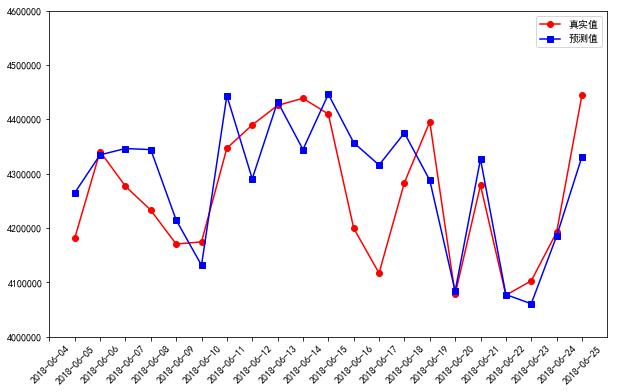

In [636]:
x_chart = StandardScaler()
y_chart = StandardScaler()
x_input_scaler = x_chart.fit_transform(X_input[:-21])
x_test = x_chart.transform(X_input[-21:])
y_train = y_chart.fit_transform(y[:-21].reshape(-1,1))
clf = SVR()
clf.fit(x_input_scaler,y_train)
y_pre = clf.predict(x_test)
fig1 = plt.figure(figsize=(10,6))
ax1 = fig1.add_subplot(1,1,1)
ax1.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m-%d'))#设置时间标签显示格式
plt.ylim((4000000, 4600000))
plt.xticks(pd.date_range('2018-06-01','2018-06-25'),rotation = 45)
plt.plot(date[-21:],y[-21:],'-ro',label = '真实值')
y_pre = y_chart.inverse_transform(y_pre)
plt.plot(date[-21:],y_pre,'-bs',label = '预测值')
plt.legend() 
print(np.mean(abs(y[-21:]-y_pre)))
print(np.mean(abs(y[-21:]-y_pre)/y[-21:]))

## Bagging + XGBoost

In [59]:
from sklearn.ensemble import BaggingRegressor
clf = xgb.XGBRegressor(colsample_bytree = 0.9,gamma = 0.1,learining_rate = 0.07,
                       max_depth = 6, min_child_weight= 4,n_estimators=110,reg_alpha = 0.1,reg_lambda = 2,subsample = 0.7)
bag_reg = BaggingRegressor(n_estimators = 30,base_estimator = xgb.XGBRegressor(colsample_bytree = 0.9,gamma = 0.1,learining_rate = 0.07,max_depth = 6, min_child_weight= 4,n_estimators=110,reg_alpha = 0.1,reg_lambda = 2,subsample = 0.7))
train_cross(bag_reg,X_input,y)
MRE(bag_reg,X_input,y)

71441.08025397337
0.015299887624233168


79125.4551724138
0.019960944357981576


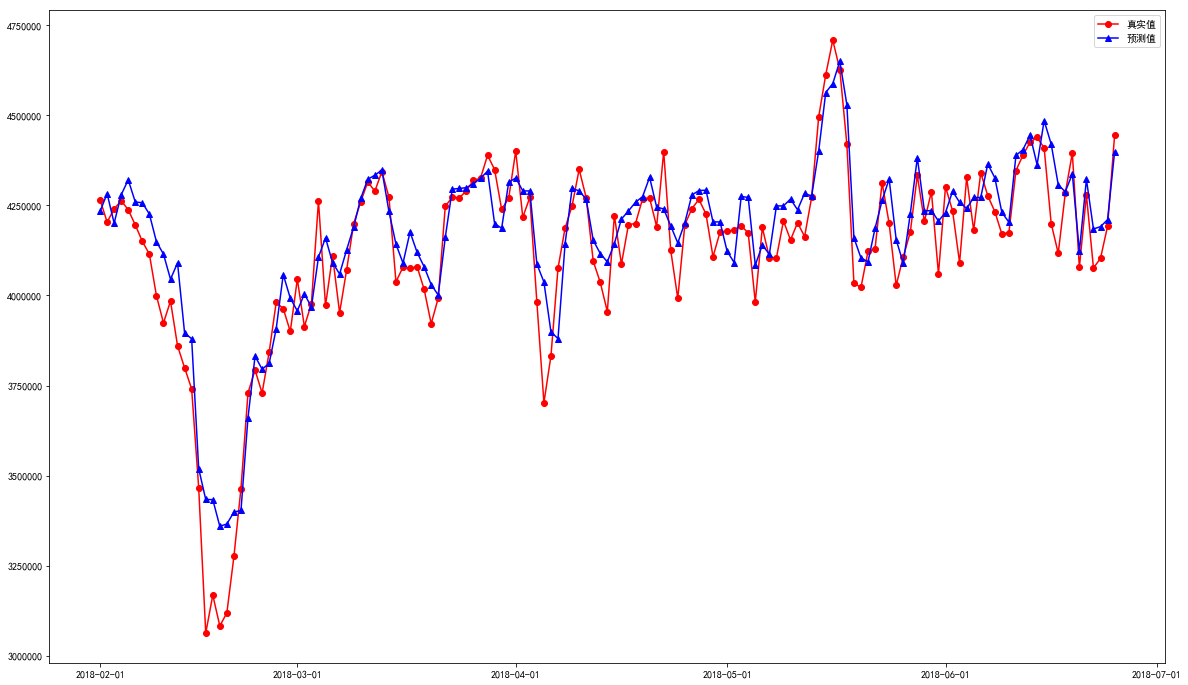

In [157]:
from sklearn.ensemble import BaggingRegressor
clf = xgb.XGBRegressor(colsample_bytree = 0.9,gamma = 0.1,learining_rate = 0.07,
                       max_depth = 6, min_child_weight= 4,n_estimators=110,reg_alpha = 0.1,reg_lambda = 2,subsample = 0.7)
bag_reg = BaggingRegressor(n_estimators = 30,base_estimator = xgb.XGBRegressor(colsample_bytree = 0.9,gamma = 0.1,learining_rate = 0.07,max_depth = 6, min_child_weight= 4,n_estimators=110,reg_alpha = 0.1,reg_lambda = 2,subsample = 0.7))
day =145
Predict_xgboost(bag_reg,X_input[:-day],y[:-day],X_input[-day:],y[-day:],day,date[-day:])